In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

# Unzip the downloaded file
with zipfile.ZipFile("/content/drive/MyDrive/Colab_Notebooks/XAI/SkinCancer.zip", 'r') as zip_ref:
    zip_ref.extractall("extracted_folder")

# List contents
import os
os.listdir("extracted_folder")

['GroundTruth.csv', 'images', 'masks']

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import onnx
import onnxruntime as ort
import shap

In [ ]:
# Verify image-mask consistency

# images and masks folder paths
image_dir = "extracted_folder/images"
mask_dir = "extracted_folder/masks"

# list of images and masks from the directory
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

# generating lis of image names (without extension) & masks names (without 'segmentation' suffix & extension)
image_names = [os.path.splitext(f)[0] for f in image_files]
mask_names = [os.path.splitext(f)[0].replace('_segmentation', '') for f in mask_files]

# checking if all the images have corresponding masks or not
missing_masks = [img for img in image_names if img not in mask_names]

if len(missing_masks) == 0:
    print('All images have corresponding masks...')
else:
    print(f'No of images that dont have corresponding masks: {len(missing_images)}')

All images have corresponding masks...


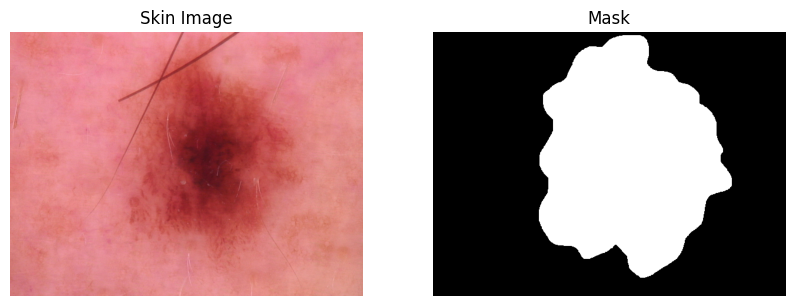

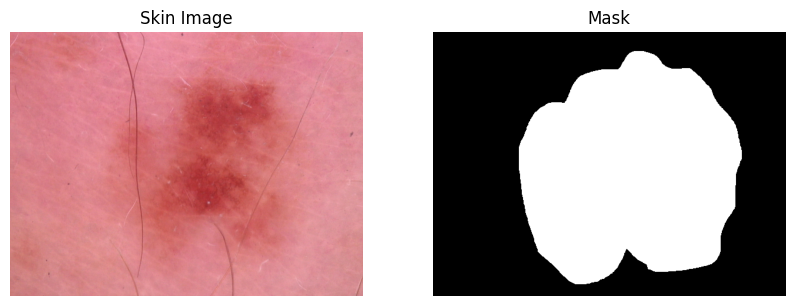

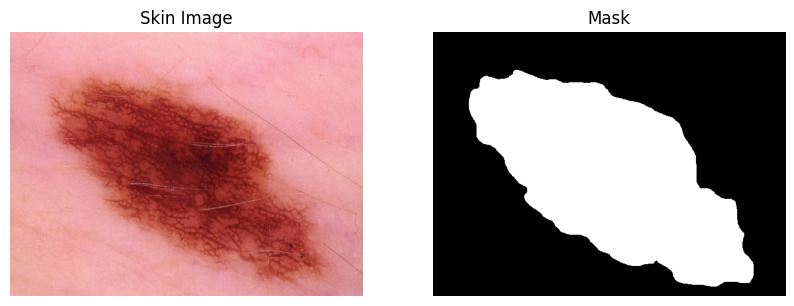

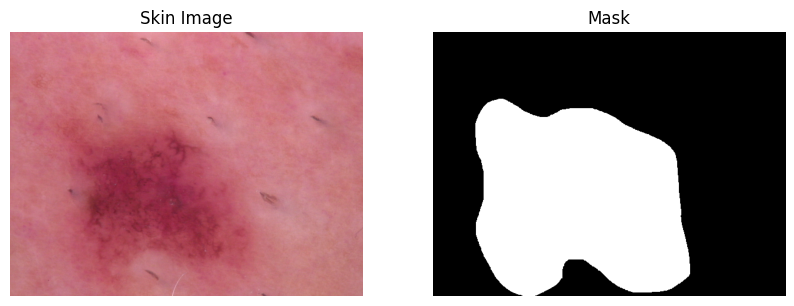

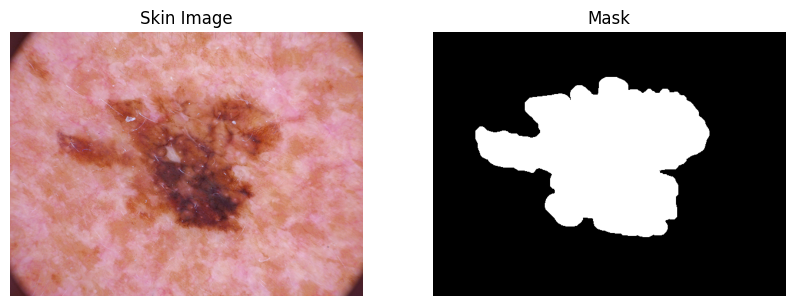

In [ ]:
# Display image and mask side by side
def display_function(image_path, mask_path):
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # side by side display
    fig, axis = plt.subplots(1, 2, figsize=(10, 5))
    axis[0].imshow(image)
    axis[0].set_title('Skin Image')
    axis[0].axis('off')

    axis[1].imshow(mask, cmap='gray')
    axis[1].set_title('Mask')
    axis[1].axis('off')

    plt.show()


# Displaying 5 images & masks
for i in range(5):
    image_path = os.path.join(image_dir, image_files[i])

    mask_name = os.path.splitext(image_files[i])[0] + '_segmentation.png'
    mask_path = os.path.join(mask_dir, mask_name)

    display_function(image_path, mask_path)


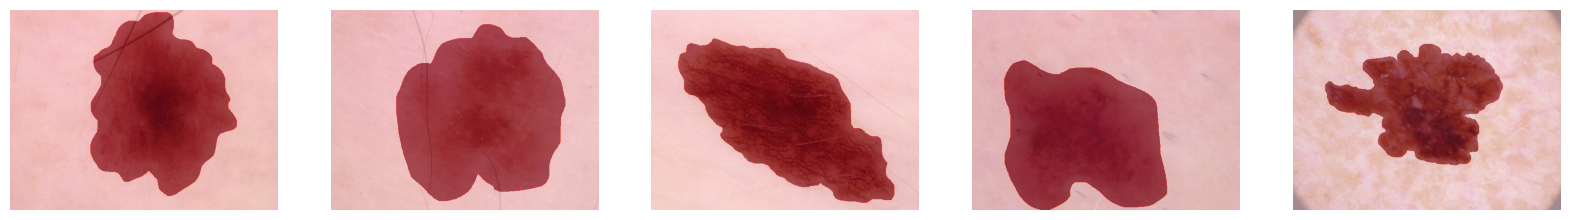

In [ ]:
#Overlay masks on images

def display_masked_images(image_path, mask_path):
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # converting image & mask to numpy array
    image_np = np.array(image)
    mask_np = np.array(mask)

    return image_np, mask_np

# displaying 5 masked images
fig, axis = plt.subplots(1, 5, figsize=(20,5))

for i in range(5):
    image_path = os.path.join(image_dir, image_files[i])

    mask_name = os.path.splitext(image_files[i])[0] + '_segmentation.png'
    mask_path = os.path.join(mask_dir, mask_name)

    image_np, mask_np = display_masked_images(image_path, mask_path)

    # display masked images
    axis[i].imshow(image_np)
    axis[i].imshow(mask_np, cmap='Reds', alpha=0.5) # alpha - to make it semi transparent
    axis[i].axis('off')

plt.show()

# **SHAP**

In [ ]:
# Function to load and preprocess images and masks
def load_image_and_mask(image_path, mask_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Resize to fit MobileNetV3
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Preprocess for MobileNetV3

    mask = image.load_img(mask_path, target_size=(224, 224), color_mode='grayscale')  # Resize mask
    mask_array = image.img_to_array(mask)  # Convert mask to array
    mask_array = np.expand_dims(mask_array, axis=0)

    return img_array, mask_array

In [ ]:
def load_onnx_model(model_path):
    try:
        onnx_model = onnx.load(model_path)
        session = ort.InferenceSession(model_path)
        return session
    except Exception as e:
        raise RuntimeError(f"Failed to load ONNX model: {e}")


# Load the ONNX model
model_path = "/content/drive/MyDrive/Colab_Notebooks/XAI/model.onnx"
session = load_onnx_model(model_path)


# Function to get the model prediction
def predict_onnx_for_shap(model_input, session):
    # Ensure input is in NCHW format
    if len(model_input.shape) == 4:  # Batch input
        model_input = model_input.transpose(0, 3, 1, 2)  # NHWC to NCHW
    elif len(model_input.shape) == 3:  # Single image
        model_input = model_input.transpose(2, 0, 1)  # HWC to CHW
        model_input = np.expand_dims(model_input, axis=0)  # Add batch dimension

    input_name = session.get_inputs()[0].name
    predictions = session.run(None, {input_name: model_input})
    return predictions[0]


def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

# Prepare baseline images for SHAP
baseline_images = []
for i in range(min(5, len(image_files))):  # Use the first 5 images as baseline
    image_path = os.path.join(image_dir, image_files[i])
    img_array = preprocess_image(image_path)
    baseline_images.append(img_array)

baseline_images = np.array(baseline_images)


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP values min: 0.0
SHAP values max: 0.0
SHAP values mean: 0.0


<ipython-input-39-79501d478015>:87: RuntimeWarning: invalid value encountered in divide
  shap_normalized = (shap_values - shap_min) / (shap_max - shap_min)
/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


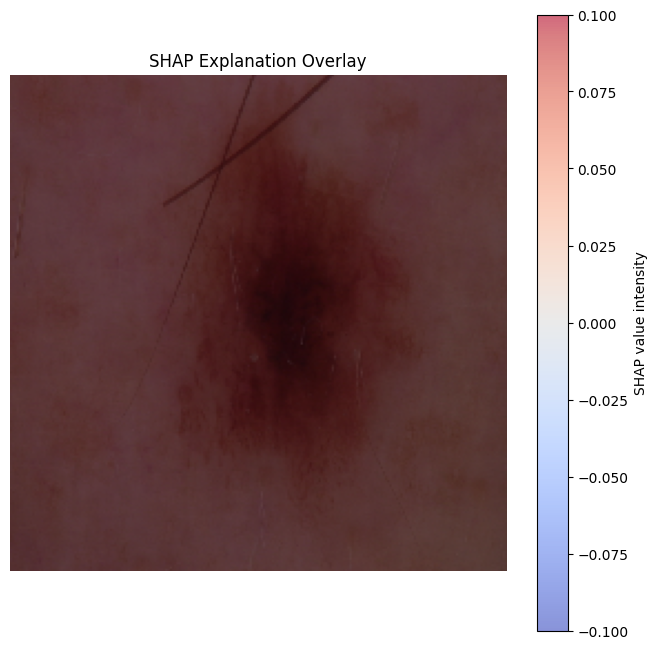

In [ ]:
# Wrapper function for SHAP with reshaping
def shap_explainer(session, single_baseline_image):
    # Flatten the single baseline image
    flattened_baseline = single_baseline_image.reshape((1, -1))

    # Wrapper for prediction that reshapes back for model input
    def predict_with_flattened_input(flat_input):
        reshaped_input = flat_input.reshape((-1, 224, 224, 3))  # Reshape back to NHWC format
        reshaped_input = reshaped_input.transpose(0, 3, 1, 2)  # Convert to NCHW for ONNX
        input_name = session.get_inputs()[0].name
        predictions = session.run(None, {input_name: reshaped_input})
        return predictions[0]

    return shap.KernelExplainer(predict_with_flattened_input, flattened_baseline)

# Select the first image as the baseline
baseline_image = baseline_images[0].reshape(1, 224, 224, 3)

# Initialize SHAP explainer with a single baseline image
explainer = shap_explainer(session, baseline_image)

# Select an image to explain (use the first image as an example)
image_array = baseline_image.reshape(1, -1)  # Flatten for SHAP explainer

# Compute SHAP values for the selected image
shap_values = explainer.shap_values(image_array)

# Compute the expected size dynamically and reshape for visualization
shap_values_flattened = np.array(shap_values)
total_elements = shap_values_flattened.size
expected_elements = 224 * 224 * 3  # Match image dimensions

if total_elements % expected_elements != 0:
    raise ValueError(f"SHAP values size {total_elements} is not a multiple of expected {expected_elements}")

# Reshape based on the expected size
shap_values_reshaped = shap_values_flattened.reshape(-1, 224, 224, 3)[0]

# Adjust SHAP normalization
def normalize_shap_values(shap_values, scale=50.0):
    max_abs_value = np.max(np.abs(shap_values))
    if max_abs_value == 0:
        return shap_values  # Avoid division by zero
    return shap_values / max_abs_value * scale

# Enhanced SHAP visualization with parameter tuning
def plot_shap_overlay(image, shap_values, alpha=1.0):
    """Overlay SHAP values on the original image with parameter adjustments."""
    # Normalize SHAP values with scaling
    normalized_shap = normalize_shap_values(shap_values, scale=10.0)

    # Use a high-contrast colormap
    cmap = plt.cm.hot  # Switch to 'hot' for perceptual contrast
    norm = mcolors.Normalize(vmin=-np.max(np.abs(shap_values_reshaped)) * 1.5,
                         vmax=np.max(np.abs(shap_values_reshaped)) * 1.5)

    # Plot the original image and SHAP overlay
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    ax.imshow(normalized_shap, cmap=cmap, norm=norm, alpha=alpha)
    ax.axis("off")
    ax.set_title("Improved SHAP Explanation Overlay", fontsize=16)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, fraction=0.046, pad=0.04)
    plt.show()

# Print SHAP value statistics for debugging
print("SHAP values min:", np.min(shap_values_reshaped))
print("SHAP values max:", np.max(shap_values_reshaped))
print("SHAP values mean:", np.mean(shap_values_reshaped))

# Improved SHAP visualization
def plot_shap_on_image(original_image, shap_values, alpha=0.6, cmap='coolwarm'):

    # Normalize SHAP values for better contrast
    shap_min, shap_max = np.min(shap_values), np.max(shap_values)
    shap_normalized = (shap_values - shap_min) / (shap_max - shap_min)

    # Create the plot
    plt.figure(figsize=(8, 8))
    plt.imshow(original_image / 255.0)  # Normalize image to [0, 1]
    plt.imshow(shap_normalized, cmap=cmap, alpha=alpha)  # SHAP overlay
    plt.colorbar(label="SHAP value intensity")
    plt.title("SHAP Explanation Overlay")
    plt.axis('off')
    plt.show()

# Use the function with the original image and SHAP values
plot_shap_on_image(
    baseline_images[0].reshape(224, 224, 3),  # Original image
    shap_values_reshaped,  # SHAP values reshaped to (224, 224, 3)
    alpha=0.6,  # Transparency
    cmap='coolwarm'  # Color map
)



This image illustrates a SHAP explanation overlay for a skin lesion. The color intensity map (ranging from red to blue) indicates the pixel-level contributions to the model's prediction:

**Red regions** represent positive SHAP values, indicating areas that strongly support the model's prediction (e.g., characteristics associated with a specific diagnosis).

**Blue regions** represent negative SHAP values, which detract from the prediction.
In this case, the model focuses primarily on the dark central area of the lesion, where the strongest contributions are concentrated. This aligns with typical diagnostic features like irregular pigmentation. However, some surrounding areas have lighter contributions, suggesting the model might also consider peripheral details. 

The model appears to assign predominantly positive SHAP values to the pixels in the image, meaning it strongly believes that the entire lesion contributes to the prediction in favor of the outcome being assessed (e.g., malignancy or some other condition).
This could indicate high confidence in the lesion's features aligning with the model's learned patterns.

  0%|          | 0/1 [00:00<?, ?it/s]

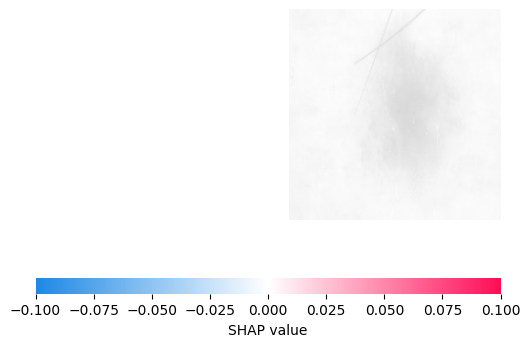

In [ ]:
# Wrapper function for SHAP with reshaping
def shap_explainer(session, single_baseline_image):
    # Flatten the single baseline image
    flattened_baseline = single_baseline_image.reshape((1, -1))

    # Wrapper for prediction that reshapes back for model input
    def predict_with_flattened_input(flat_input):
        reshaped_input = flat_input.reshape((-1, 224, 224, 3))  # Reshape back to NHWC format
        reshaped_input = reshaped_input.transpose(0, 3, 1, 2)  # Convert to NCHW for ONNX
        input_name = session.get_inputs()[0].name
        predictions = session.run(None, {input_name: reshaped_input})
        return predictions[0]

    return shap.KernelExplainer(predict_with_flattened_input, flattened_baseline)

# Select the first image as the baseline
baseline_image = baseline_images[0].reshape(1, 224, 224, 3)

# Initialize SHAP explainer with a single baseline image
explainer = shap_explainer(session, baseline_image)

# Select an image to explain (use the first image as an example)
image_array = baseline_image.reshape(1, -1)  # Flatten for SHAP explainer

# Compute SHAP values for the selected image
shap_values = explainer.shap_values(image_array)

# Compute the expected size dynamically and reshape for visualization
shap_values_flattened = np.array(shap_values)
total_elements = shap_values_flattened.size
expected_elements = 224 * 224 * 3  # Match image dimensions

if total_elements % expected_elements != 0:
    raise ValueError(f"SHAP values size {total_elements} is not a multiple of expected {expected_elements}")

# Reshape based on the expected size
shap_values_reshaped = shap_values_flattened.reshape(-1, 224, 224, 3)[0]

shap.image_plot(
    [shap_values_reshaped],
    baseline_images[0].reshape(224, 224, 3)  # Remove the unnecessary batch dimension
)

the visual parameters for this one were not that good adjusted so there is no  need to include this

In [ ]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00
